In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install -qqq ftfy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

## for opening, manipulating, and saving many different image file f
from PIL import Image

import random 

## for plotting
import matplotlib.pyplot as plt

## for processing
import nltk
nltk.download('omw-1.4')
import re
import ftfy
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 

#for expanding contracted words
import sys  
!{sys.executable} -m pip install contractions
import contractions

## WordCloud - Python linrary for creating image wordclouds
from wordcloud import WordCloud
from nltk import pos_tag ## For Parts of Speech tagging

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.9 MB/s eta 0:00:00


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 16.5 MB/s eta 0:00:00


SELECTING DATASETS

In [3]:
ds_all = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Eye_Data.csv")
ds_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Virahonda.csv")
ds_test_kom = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Suicide_Detection_komati.csv")

In [4]:
print(ds_test_kom.head())

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


In [5]:
ds_test_kom=ds_test_kom.loc[ds_test_kom['class'] == 'suicide']
print(ds_test_kom.head())
ds_test_kom=ds_test_kom.sample(n = 50000,replace = False)
ds_test_kom.reset_index(inplace=True)

   Unnamed: 0                                               text    class
0           2  Ex Wife Threatening SuicideRecently I left my ...  suicide
3           8          i need helpjust help me im crying so hard  suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...  suicide
5          11  Honetly idkI dont know what im even doing here...  suicide
6          12  [Trigger warning] Excuse for self inflicted bu...  suicide


In [6]:
print("eye: ",ds_all.shape)
print("virahonda: ",ds_test.shape)
print("komati: ",ds_test_kom.shape)

eye:  (10314, 3)
virahonda:  (7145, 1)
komati:  (50000, 4)


In [7]:
print(ds_all.dtypes.to_frame().rename(columns={0:'data_type'}))

           data_type
Unnamed: 0     int64
message       object
label          int64


In [8]:
#ds_all.rename(columns = {'text':'message'}, inplace = True)

REMOVING UNWANTED COLOUMNS FROM DATASETS

In [9]:
# # required only for Eye dataset
ds_all.drop(columns=['Unnamed: 0'], inplace=True)
ds_test['label'] = 1

In [10]:
#  old name - text, new - message
print(ds_all.isnull().sum().to_frame().rename(columns={0:'Null values'}))

         Null values
message            0
label              0


In [11]:
ds_test.rename(columns = {'Comments Text':'message'}, inplace = True)
print(ds_test.isnull().sum().to_frame().rename(columns={0:'Null values'}))

         Null values
message            0
label              0


In [12]:
ds_test_kom.drop(columns=['Unnamed: 0','class','index'], inplace=True)
ds_test_kom.rename(columns = {'text':'message'}, inplace = True)
ds_test_kom['label'] = 1
print(ds_test_kom.isnull().sum().to_frame().rename(columns={0:'Null values'}))

         Null values
message            0
label              0


DATASET NOISE CLEANING (PRE-PROCESSING)

In [13]:
def expandContracted(sentence):
  expanded_words = []   
  for word in sentence.split():
    # using contractions.fix to expand the shortened words
    expanded_words.append(contractions.fix(word))  
  res = ' '.join(expanded_words)
  return res

In [14]:
# LEMMATIZATION WITH POS TAG
# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
	if nltk_tag.startswith('J'):
		return wordnet.ADJ
	elif nltk_tag.startswith('V'):
		return wordnet.VERB
	elif nltk_tag.startswith('N'):
		return wordnet.NOUN
	elif nltk_tag.startswith('R'):
		return wordnet.ADV
	else:		
		return None

def lemmatize_func(text):
  lemmatizer = WordNetLemmatizer()
  # tokenize the sentence and find the POS tag for each token
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))

  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
    if tag is None:
      lemmatized_sentence.append(word)
    else:
      lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  lemmatized_sentence = " ".join(lemmatized_sentence)

  return lemmatized_sentence

In [15]:
# PRE-PROCESSING FUNCTION
def cleaning_process(input_tweets, input_labels):
  cleaned_tweets = []
  cleaned_labels = []
  for (a_tweet, a_label) in zip(input_tweets, input_labels):

    #convert to lowercase
    a_tweet = a_tweet.lower()
    
    # if url links then don't append to avoid news articles
    # also check tweet length, save those > 5 
    if re.match("(\w+:\/\/\S+)", a_tweet) == None and len(a_tweet) > 5:
      #remove @mention
      a_tweet = re.sub(r"(?:\@|https?\://)\S+", "", a_tweet)

      #remove punctuation
      a_tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", a_tweet).split())

      #remove hashtag, @mention, HTML tags and image URLs
      a_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<.>)|(pic\.twitter\.com\/.*)", " ", a_tweet).split())
      
      #remove numbers
      a_tweet = re.sub(r'\d+', '', a_tweet)

      #remove urls
      a_tweet = re.sub(r'https?://\S+|www\.\S+', '', a_tweet)

      #fix weirdly encoded texts (Unicode correction)
      a_tweet = ftfy.fix_text(a_tweet)

      #stop words
      stop_words = set(stopwords.words('english'))
      word_tokens = nltk.word_tokenize(a_tweet)
      a_tweet = [word for word in word_tokens if not word in stop_words]
      a_tweet = ' '.join(a_tweet) # join words with a space in between them

      #expand contraction
      a_tweet = expandContracted(a_tweet)

      #lemmatization
      a_tweet = lemmatize_func(a_tweet)

      #removing depression and diagnosis
      a_tweet = re.sub("depression",'', a_tweet)
      a_tweet = re.sub("diagnose", '', a_tweet)

      cleaned_tweets.append(a_tweet)
      cleaned_labels.append(a_label)
  return (cleaned_tweets, cleaned_labels)

CLEANING OF EYE DATASET

In [16]:
ds_text_all_arr = [x for x in ds_all['message']]
ds_label_all_arr = [x for x in ds_all['label']]
(cleaned_ds_text_all_arr, cleaned_ds_labels_all_arr) = cleaning_process(ds_text_all_arr, ds_label_all_arr)

CLEANING OF VIRAHONDA DATASET

In [17]:
ds_text_test_arr = [x for x in ds_test['message']]
ds_label_test_arr = [x for x in ds_test['label']]
(cleaned_ds_text_test_arr, cleaned_ds_labels_test_arr) = cleaning_process(ds_text_test_arr, ds_label_test_arr)

CLEANING OF KOMATI DATASET

In [18]:
ds_text_test_kom_arr = [x for x in ds_test_kom['message']]
ds_label_test_kom_arr = [x for x in ds_test_kom['label']]
(cleaned_ds_text_test_kom_arr, cleaned_ds_labels_test_kom_arr) = cleaning_process(ds_text_test_kom_arr, ds_label_test_kom_arr)

In [19]:
print(ds_text_all_arr[:10])

['just had a real good moment. i missssssssss him so much, ', 'is reading manga  http://plurk.com/p/mzp1e', '@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8 ', "@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though. ", 'ADD ME ON MYSPACE!!!  myspace.com/LookThunder', 'so sleepy. good times tonight though ', '@SilkCharm re: #nbn as someone already said, does fiber to the home mean we will all at least be regular now ', '23 or 24ï¿½C possible today. Nice ', 'nite twitterville  workout in the am  -ciao', "@daNanner Night, darlin'!  Sweet dreams to you "]


In [20]:
print(cleaned_ds_text_all_arr[:10])

['real good moment miss much', 'reading manga', '', 'need send them accountant tomorrow oddly even refer tax support evidence though', 'add myspace myspace com lookthunder', 'sleepy good time tonight though', 'nbn someone already say fiber home mean least regular', 'c possible today nice', 'nite twitterville workout ciao', 'night darlin sweet dream']


WORD CLOUDS

In [21]:
ds_depressed = []
ds_notdepressed = []

for (text, label) in zip(cleaned_ds_text_all_arr, cleaned_ds_labels_all_arr):
  if label == 1:
    ds_depressed.append(text)
  else:
    ds_notdepressed.append(text)

In [ ]:
str_depressed = ' '.join(ds_depressed)
str_notdepressed = ' '.join(ds_notdepressed)
str_vir = ' '.join(cleaned_ds_text_test_arr)
str_kom = ' '.join(cleaned_ds_text_test_kom_arr)

In [ ]:
image = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Dataset/logo.jpeg'))

fig = plt.figure() # Instantiate the figure object
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

<Figure size 1400x1800 with 0 Axes>

In [ ]:
def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

WORD CLOUD FOR EYE DATASET DEPRESSED

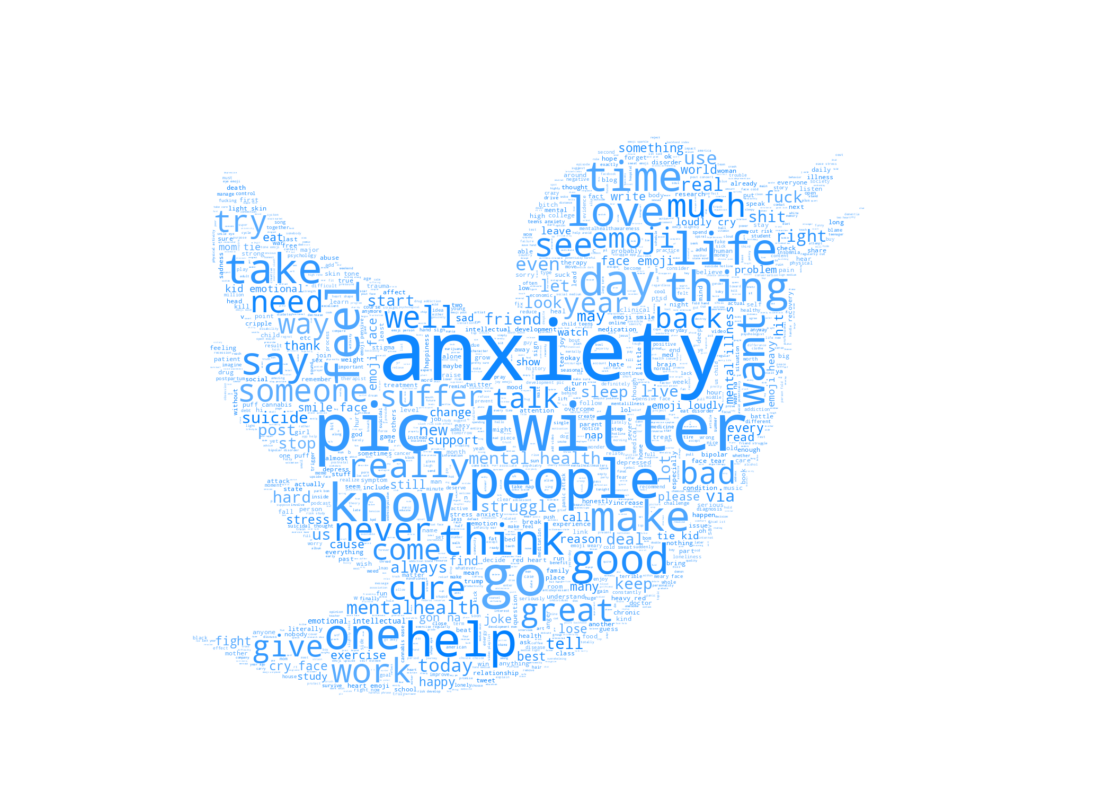

In [ ]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_depressed)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
plt.axis('off')
plt.show()

WORD CLOUD FOR EYE DATASET NOT DEPRESSED

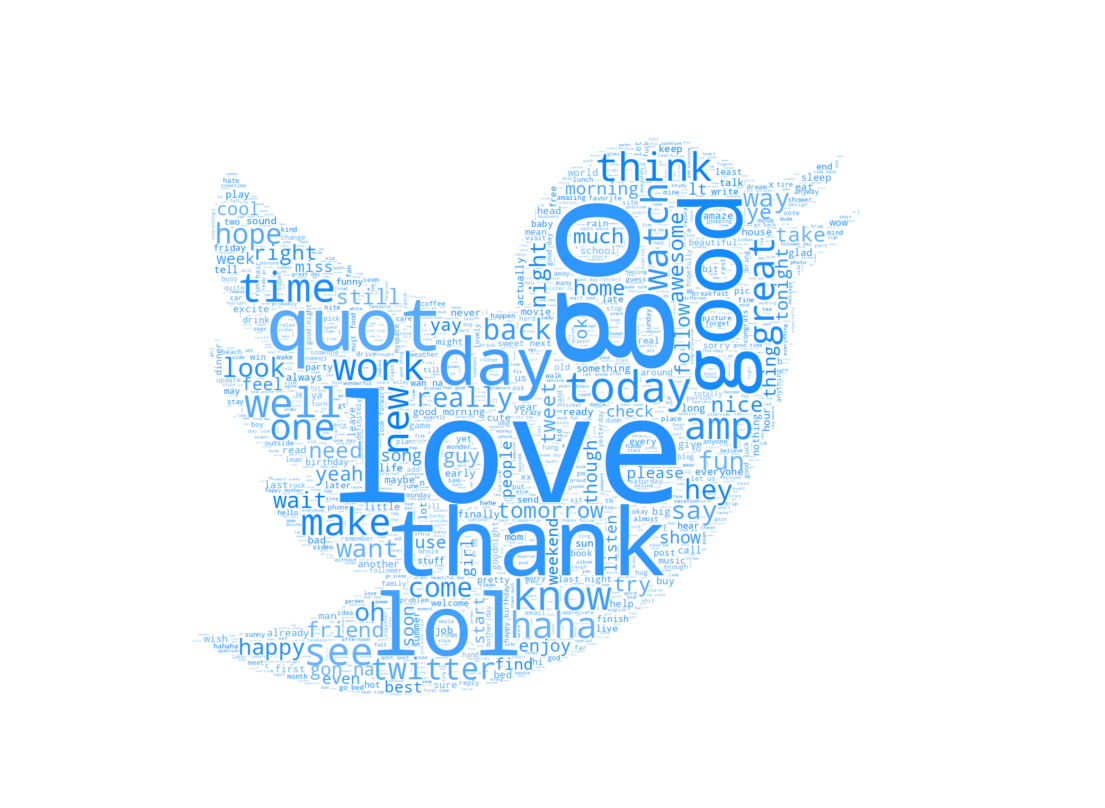

In [ ]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_notdepressed)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

WORD CLOUD FOR VIRAHONDA DATASET

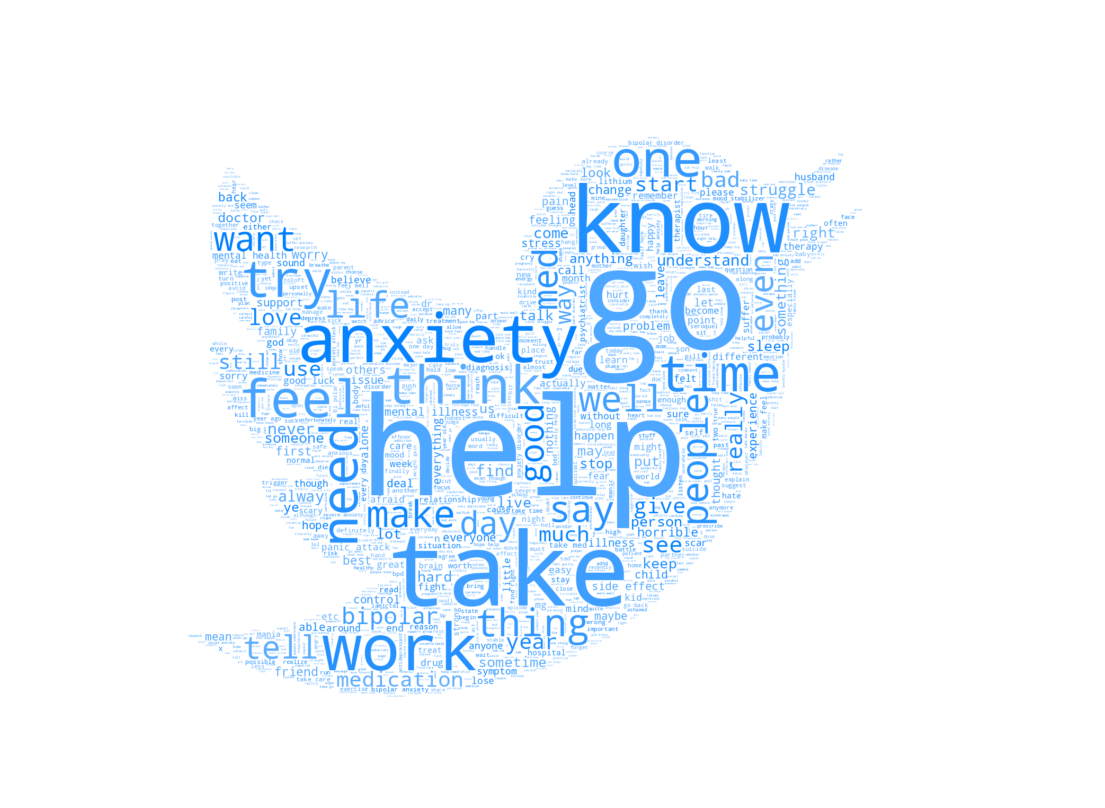

In [ ]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_vir)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
plt.axis('off')
plt.show()

WORD CLOUD FOR KOMATI DATASET

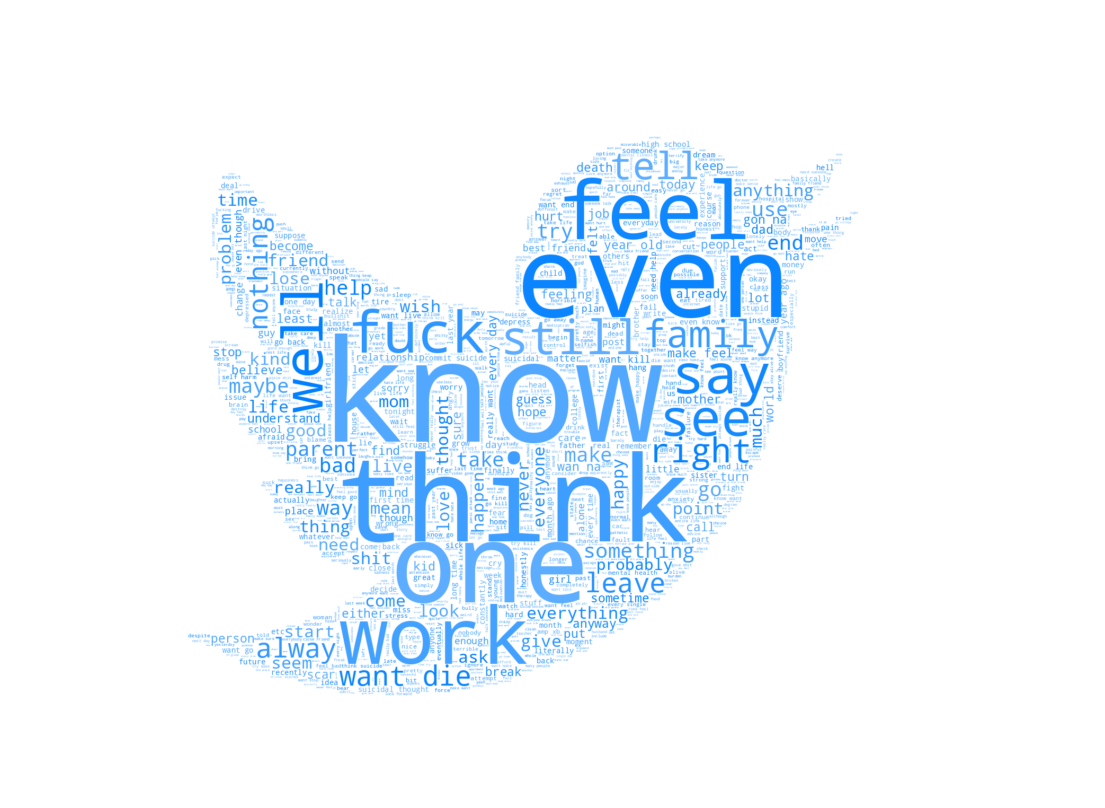

In [ ]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_kom)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
plt.axis('off')
plt.show()

BAG OF WORDS

In [22]:
from collections import Counter
from itertools import chain
from nltk.util import ngrams
from nltk.util import bigrams

def bow_for_line(corpus, top_words):
  bag_of_words = []
  for doc in corpus:
    unigram_words = doc
    bigram_words = list(bigrams(doc))
    trigram_words = list(ngrams(doc, 3))
    
    word_counts = Counter(doc)
    bigram_word_counts = Counter(bigram_words)
    trigram_word_counts = Counter(trigram_words)

    word_count=dict(word_counts)
    word_count.update(dict(bigram_word_counts))
    word_count.update(dict(trigram_word_counts))

    dict_words = dict(word_count)
    line_words = Counter(dict_words)

    row = [line_words[word] if word in line_words else 0 for word in top_words]
    bag_of_words.append(row)

  return bag_of_words

def bow(data_train):
  # Preprocess and tokenize the corpus
  corpus = [nltk.word_tokenize(doc.lower()) for doc in data_train]

  # Calculate the frequency of each word in the corpus
  word_counts = Counter(chain.from_iterable(corpus))

  bigram_words = []
  for doc in corpus:
    words = list(bigrams(doc))
    bigram_words.append(words)

  # Calculate the frequency of each bi and trigram words in the corpus
  bigram_word_counts = Counter(chain.from_iterable(bigram_words))

  trigram_words = []
  for doc in corpus:
    words = list(ngrams(doc, 3))
    trigram_words.append(words)

  trigram_word_counts = Counter(chain.from_iterable(trigram_words))

  word_count=dict(word_counts)
  word_count.update(dict(bigram_word_counts))
  word_count.update(dict(trigram_word_counts))

  word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
  dict_words = dict(word_count)
  final_words = Counter(dict_words)

  # # Select the top k most frequent words as columns
  top_words = [word for word, count in final_words.most_common(5000)]

  # # # Create the bag of words matrix
  bag_of_words = bow_for_line(corpus, top_words)
  
  return bag_of_words, top_words

BOW for EYE

In [23]:
bag_of_words, top_words = bow(cleaned_ds_text_all_arr)

print(len(bag_of_words[0]))
print(len(top_words))

5000
5000


In [24]:
column_words = []
for word in top_words:
  if isinstance(word, tuple):
    column_words.append(" ".join(word))
  else:
    column_words.append(word)

In [25]:
df = pd.DataFrame (bag_of_words, columns = column_words)
df.head()

,get,go,good,day,love,like,twitter,be,you,know,...,day people,glad work,night fun,friend would,amp go,watch hannah,song quot,think love,quot real,weight lift
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X = df
y = cleaned_ds_labels_all_arr
print(len(X), len(y))

10237 10237


BOW for VIRAHONDA

In [27]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in cleaned_ds_text_test_arr]

bag_of_words_test = bow_for_line(corpus, top_words)

In [28]:
test_df = pd.DataFrame (bag_of_words_test, columns = column_words)

In [29]:
test_df.head()

,get,go,good,day,love,like,twitter,be,you,know,...,day people,glad work,night fun,friend would,amp go,watch hannah,song quot,think love,quot real,weight lift
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,2,0,2,2,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,3,4,3,0,1,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
X_vir = test_df
y_vir = cleaned_ds_labels_test_arr
len(X_vir), len(y_vir)

(7139, 7139)

BOW for KOMATI

In [31]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in cleaned_ds_text_test_kom_arr]

bag_of_words_test_kom = bow_for_line(corpus, top_words)

In [32]:
test_df_kom = pd.DataFrame (bag_of_words_test_kom, columns = column_words)

In [33]:
test_df_kom.head()

,get,go,good,day,love,like,twitter,be,you,know,...,day people,glad work,night fun,friend would,amp go,watch hannah,song quot,think love,quot real,weight lift
0,8,0,1,3,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
X_kom = test_df_kom
y_kom = cleaned_ds_labels_test_kom_arr
len(X_kom), len(y_kom)

(49991, 49991)

BOW for EYE DEPRESSED

In [35]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in ds_depressed]

bag_of_words_test_dep = bow_for_line(corpus, top_words)

In [36]:
test_df_dep = pd.DataFrame (bag_of_words_test_dep, columns = column_words)

In [37]:
test_df_dep.head()

,get,go,good,day,love,like,twitter,be,you,know,...,day people,glad work,night fun,friend would,amp go,watch hannah,song quot,think love,quot real,weight lift
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
X_dep = test_df_dep
y_dep=[]
for x in cleaned_ds_labels_all_arr:
  if x==1:
    y_dep.append(x)
len(X_dep), len(y_dep)

(2312, 2312)

BOW for EYE NOT DEPRESSED

In [39]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in ds_notdepressed]

bag_of_words_test_ndep = bow_for_line(corpus, top_words)

In [40]:
test_df_ndep = pd.DataFrame (bag_of_words_test_ndep, columns = column_words)

In [41]:
test_df_ndep.head()

,get,go,good,day,love,like,twitter,be,you,know,...,day people,glad work,night fun,friend would,amp go,watch hannah,song quot,think love,quot real,weight lift
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X_ndep = test_df_ndep
y_ndep=[]
for x in cleaned_ds_labels_all_arr:
  if x==0:
    y_ndep.append(x)
len(X_ndep), len(y_ndep)

(7925, 7925)

10 - FOLD CROSS VALIDATION FOR MODELS

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True)
splits=list(kf.split(X,y))
splits_test_vir=list(kf.split(X_vir,y_vir))
splits_test_kom=list(kf.split(X_kom,y_kom))
splits_test_dep=list(kf.split(X_dep,y_dep))
splits_test_ndep=list(kf.split(X_ndep,y_ndep))

LOGISTIC REGRESSION

In [ ]:
LogReg_scores_eye = []
LogReg_scores_vir = []
LogReg_scores_kom = []
LogReg_scores_dep = []
LogReg_scores_ndep = []
LogReg_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_Log = LogisticRegression()
  model_Log.fit(X_train, y_train)
  y_pred = model_Log.predict(X_test)
  
  print("Fold - {} completed".format(k))

  #Eye testing
  LogReg_scores_eye.append(model_Log.score(X_test, y_test))
  y_pred_eye = model_Log.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  LogReg_scores_vir.append(model_Log.score(X_test_vir, y_test_vir))

  #Komati testing
  LogReg_scores_kom.append(model_Log.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  LogReg_scores_dep.append(model_Log.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  LogReg_scores_ndep.append(model_Log.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_eye)*100 + np.std(LogReg_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_vir)*100 + np.std(LogReg_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_kom)*100 + np.std(LogReg_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_dep)*100 + np.std(LogReg_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_ndep)*100 + np.std(LogReg_scores_ndep)*100))

LogReg_scores.append(np.mean(LogReg_scores_eye)*100 + np.std(LogReg_scores_eye)*100)
LogReg_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
LogReg_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
LogReg_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
LogReg_scores.append(np.mean(LogReg_scores_dep)*100 + np.std(LogReg_scores_dep)*100)
LogReg_scores.append(np.mean(LogReg_scores_ndep)*100 + np.std(LogReg_scores_ndep)*100)
LogReg_scores.append(np.mean(LogReg_scores_kom)*100 + np.std(LogReg_scores_kom)*100)
LogReg_scores.append(np.mean(LogReg_scores_vir)*100 + np.std(LogReg_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy LogReg: 92.2171
CV F1 score: 87.8415
CV Precision: 93.2834
CV Recall: 85.0145


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy LogReg: 81.9074


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy LogReg: 88.7763


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy LogReg: 82.4479


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy LogReg: 99.7445


LSVM

In [ ]:
LSVM_scores_eye = []
LSVM_scores_vir = []
LSVM_scores_kom = []
LSVM_scores_dep = []
LSVM_scores_ndep = []
LSVM_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_LSVM = LinearSVC()
  model_LSVM.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  LSVM_scores_eye.append(model_LSVM.score(X_test, y_test))
  y_pred_eye = model_LSVM.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  LSVM_scores_vir.append(model_LSVM.score(X_test_vir, y_test_vir))

  #Komati testing
  LSVM_scores_kom.append(model_LSVM.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  LSVM_scores_dep.append(model_LSVM.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  LSVM_scores_ndep.append(model_LSVM.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_eye)*100 + np.std(LSVM_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_vir)*100 + np.std(LSVM_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_kom)*100 + np.std(LSVM_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_dep)*100 + np.std(LSVM_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_ndep)*100 + np.std(LSVM_scores_ndep)*100))

LSVM_scores.append(np.mean(LSVM_scores_eye)*100 + np.std(LSVM_scores_eye)*100)
LSVM_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
LSVM_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
LSVM_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
LSVM_scores.append(np.mean(LSVM_scores_dep)*100 + np.std(LSVM_scores_dep)*100)
LSVM_scores.append(np.mean(LSVM_scores_ndep)*100 + np.std(LSVM_scores_ndep)*100)
LSVM_scores.append(np.mean(LSVM_scores_kom)*100 + np.std(LSVM_scores_kom)*100)
LSVM_scores.append(np.mean(LSVM_scores_vir)*100 + np.std(LSVM_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy LSVM: 91.4547
CV F1 score: 87.2638
CV Precision: 89.3885
CV Recall: 86.1308


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy LSVM: 80.9903


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy LSVM: 86.3492


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy LSVM: 94.0315


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy LSVM: 99.7366


MLP

In [ ]:
MLP_scores_eye = []
MLP_scores_vir = []
MLP_scores_kom = []
MLP_scores_dep = []
MLP_scores_ndep = []
MLP_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_MLP = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10)
  model_MLP.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  MLP_scores_eye.append(model_MLP.score(X_test, y_test))
  y_pred_eye = model_MLP.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  MLP_scores_vir.append(model_MLP.score(X_test_vir, y_test_vir))

  #Komati testing
  MLP_scores_kom.append(model_MLP.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  MLP_scores_dep.append(model_MLP.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  MLP_scores_ndep.append(model_MLP.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_eye)*100 + np.std(MLP_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_vir)*100 + np.std(MLP_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_kom)*100 + np.std(MLP_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_dep)*100 + np.std(MLP_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_ndep)*100 + np.std(MLP_scores_ndep)*100))

MLP_scores.append(np.mean(MLP_scores_eye)*100 + np.std(MLP_scores_eye)*100)
MLP_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
MLP_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
MLP_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
MLP_scores.append(np.mean(MLP_scores_dep)*100 + np.std(MLP_scores_dep)*100)
MLP_scores.append(np.mean(MLP_scores_ndep)*100 + np.std(MLP_scores_ndep)*100)
MLP_scores.append(np.mean(MLP_scores_kom)*100 + np.std(MLP_scores_kom)*100)
MLP_scores.append(np.mean(MLP_scores_vir)*100 + np.std(MLP_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy MLP: 92.4850
CV F1 score: 88.7240
CV Precision: 91.4973
CV Recall: 87.1672


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy MLP: 81.3746


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy MLP: 84.8779


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy MLP: 93.8048


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy MLP: 99.7519


DECISION TREE

In [ ]:
DT_scores_eye = []
DT_scores_vir = []
DT_scores_kom = []
DT_scores_dep = []
DT_scores_ndep = []
DT_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_DT = DecisionTreeClassifier()
  model_DT.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  DT_scores_eye.append(model_DT.score(X_test, y_test))
  y_pred_eye = model_DT.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  DT_scores_vir.append(model_DT.score(X_test_vir, y_test_vir))

  #Komati testing
  DT_scores_kom.append(model_DT.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  DT_scores_dep.append(model_DT.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  DT_scores_ndep.append(model_DT.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_eye)*100 + np.std(DT_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_vir)*100 + np.std(DT_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_kom)*100 + np.std(DT_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_dep)*100 + np.std(DT_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_ndep)*100 + np.std(DT_scores_ndep)*100))

DT_scores.append(np.mean(DT_scores_eye)*100 + np.std(DT_scores_eye)*100)
DT_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
DT_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
DT_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
DT_scores.append(np.mean(DT_scores_dep)*100 + np.std(DT_scores_dep)*100)
DT_scores.append(np.mean(DT_scores_ndep)*100 + np.std(DT_scores_ndep)*100)
DT_scores.append(np.mean(DT_scores_kom)*100 + np.std(DT_scores_kom)*100)
DT_scores.append(np.mean(DT_scores_vir)*100 + np.std(DT_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy DT: 87.0362
CV F1 score: 81.4248
CV Precision: 81.4746
CV Recall: 81.6212


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy DT: 79.9567


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy DT: 76.2795


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy DT: 96.5145


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy DT: 99.2096


RESULT

In [ ]:
LogReg_scores = [round(float(LogReg_scores[i]), 2) for i in range(0, len(LogReg_scores))]
LSVM_scores = [round(float(LSVM_scores[i]), 2) for i in range(0, len(LSVM_scores))]
MLP_scores = [round(float(MLP_scores[i]), 2) for i in range(0, len(MLP_scores))]
DT_scores = [round(float(DT_scores[i]), 2) for i in range(0, len(DT_scores))]

In [ ]:
LogReg_scores.insert(0, "LR")
LSVM_scores.insert(0, "LSVM")
MLP_scores.insert(0, "MLP")
DT_scores.insert(0, "DT")

In [ ]:
scores = []
scores.append(LogReg_scores)
scores.append(LSVM_scores)
scores.append(MLP_scores)
scores.append(DT_scores)

In [ ]:
scores

[['LR', 92.22, 93.28, 85.01, 87.84, 82.45, 99.74, 88.78, 81.91],
 ['LSVM', 91.45, 89.39, 86.13, 87.26, 94.03, 99.74, 86.35, 80.99],
 ['MLP', 92.48, 91.5, 87.17, 88.72, 93.8, 99.75, 84.88, 81.37],
 ['DT', 87.04, 81.47, 81.62, 81.42, 96.51, 99.21, 76.28, 79.96]]

In [ ]:
df = pd.DataFrame(scores, columns=['Classifier', 'Acc', 'Prec', 'Rec', 'F1', 'Dep', 'Non-Dep', 'Kom', 'Vir'])

In [ ]:
df

,Classifier,Acc,Prec,Rec,F1,Dep,Non-Dep,Kom,Vir
0,LR,92.22,93.28,85.01,87.84,82.45,99.74,88.78,81.91
1,LSVM,91.45,89.39,86.13,87.26,94.03,99.74,86.35,80.99
2,MLP,92.48,91.50,87.17,88.72,93.80,99.75,84.88,81.37
3,DT,87.04,81.47,81.62,81.42,96.51,99.21,76.28,79.96


GRAPH PLOTTING

In [ ]:
w=0.2
x = df['Classifier']
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]

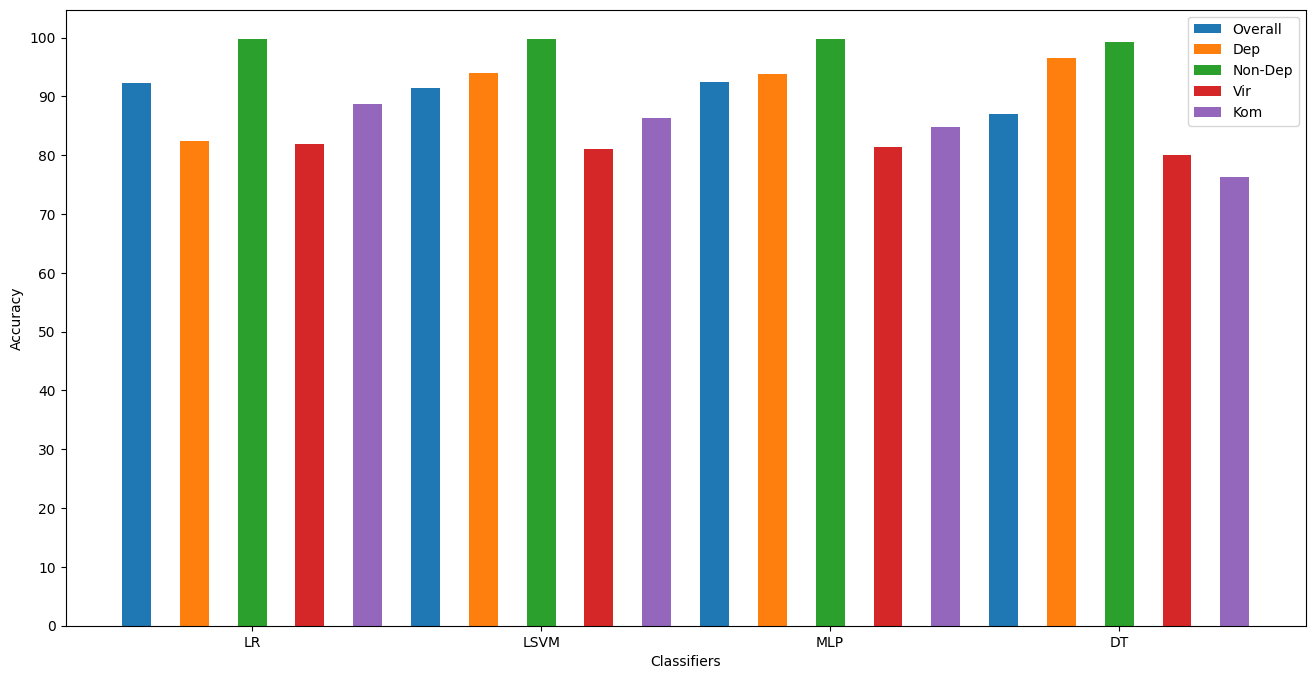

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(bar1, df['Acc'], label='Overall', align='edge', width=0.1)
plt.bar(bar2, df['Dep'], align='edge', width=0.1, label='Dep')
plt.bar(bar3, df['Non-Dep'], align='edge', width=0.1, label='Non-Dep')
plt.bar(bar4, df['Vir'], align='edge', width=0.1, label='Vir')
plt.bar(bar5, df['Kom'], align='edge', width=0.1, label='Kom')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.xticks(bar1+0.45, x)
plt.yticks(np.arange(0, 101, 10))
plt.legend(loc='upper right')
plt.show()

PLOTTING DECISION TREE

In [ ]:
# X_dep = test_df_dep.iloc[:50, :10]
# X_notDep = test_df_ndep.iloc[:50, :10]
# X_tree = X_dep.append(X_notDep, ignore_index=True)
# X_tree.shape

In [ ]:
# y_dep = [1 for i in range(0, 50)]
# y_notDep = [0 for i in range(0, 50)]
# y_tree = []
# y_tree.extend(y_dep)
# y_tree.extend(y_notDep)
# len(y_tree)

In [ ]:
# X_tree.head()

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn import tree
# from sklearn import metrics

In [ ]:
# X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y_tree, test_size=0.3) # 70% training and 30% test
# model = DecisionTreeClassifier(criterion="gini",max_depth=8)
# model.fit(X_tree_train, y_tree_train)

In [ ]:
# fig = plt.figure(figsize=(25,20))
# figPlt = tree.plot_tree(model, feature_names=column_words[:10], class_names=["ndep", "dep"], filled=True)

In [ ]:
# y_pred_tree = model.predict(X_tree_test)

In [ ]:
# print("Accuracy:",metrics.accuracy_score(y_tree_test, y_pred_tree))

In [ ]:
# model1 = DecisionTreeClassifier(criterion="entropy",max_depth=8)
# model1.fit(X_tree_train, y_tree_train)

In [ ]:
# fig = plt.figure(figsize=(25,20))
# figPlt = tree.plot_tree(model1, feature_names=column_words[:10], class_names=["ndep", "dep"], filled=True)

In [ ]:
# y_pred_tree1 = model1.predict(X_tree_test)

In [ ]:
# print("Accuracy:",metrics.accuracy_score(y_tree_test, y_pred_tree1))

ENSEMBLE CLASSIFIERS

Adaptive Boosting

In [44]:
from sklearn.ensemble import AdaBoostClassifier
AB_scores_eye = []
AB_scores_vir = []
AB_scores_kom = []
AB_scores_dep = []
AB_scores_ndep = []
AB_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_AB = AdaBoostClassifier()
  model_AB.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  AB_scores_eye.append(model_AB.score(X_test, y_test))
  y_pred_eye = model_AB.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  AB_scores_vir.append(model_AB.score(X_test_vir, y_test_vir))

  #Komati testing
  AB_scores_kom.append(model_AB.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  AB_scores_dep.append(model_AB.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  AB_scores_ndep.append(model_AB.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_eye)*100 + np.std(AB_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_vir)*100 + np.std(AB_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_kom)*100 + np.std(AB_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_dep)*100 + np.std(AB_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_ndep)*100 + np.std(AB_scores_ndep)*100))

AB_scores.append(np.mean(AB_scores_eye)*100 + np.std(AB_scores_eye)*100)
AB_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
AB_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
AB_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
AB_scores.append(np.mean(AB_scores_dep)*100 + np.std(AB_scores_dep)*100)
AB_scores.append(np.mean(AB_scores_ndep)*100 + np.std(AB_scores_ndep)*100)
AB_scores.append(np.mean(AB_scores_kom)*100 + np.std(AB_scores_kom)*100)
AB_scores.append(np.mean(AB_scores_vir)*100 + np.std(AB_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy AB: 89.5370
CV F1 score: 82.8184
CV Precision: 90.5988
CV Recall: 78.9689


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy AB: 72.0929


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy AB: 73.6200


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy AB: 61.9369


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy AB: 98.8809


In [45]:
from sklearn.ensemble import BaggingClassifier
Bag_scores_eye = []
Bag_scores_vir = []
Bag_scores_kom = []
Bag_scores_dep = []
Bag_scores_ndep = []
Bag_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_Bag = BaggingClassifier()
  model_Bag.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  Bag_scores_eye.append(model_Bag.score(X_test, y_test))
  y_pred_eye = model_Bag.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  Bag_scores_vir.append(model_Bag.score(X_test_vir, y_test_vir))

  #Komati testing
  Bag_scores_kom.append(model_Bag.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  Bag_scores_dep.append(model_Bag.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  Bag_scores_ndep.append(model_Bag.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_eye)*100 + np.std(Bag_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_vir)*100 + np.std(Bag_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_kom)*100 + np.std(Bag_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_dep)*100 + np.std(Bag_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_ndep)*100 + np.std(Bag_scores_ndep)*100))

Bag_scores.append(np.mean(Bag_scores_eye)*100 + np.std(Bag_scores_eye)*100)
Bag_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
Bag_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
Bag_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
Bag_scores.append(np.mean(Bag_scores_dep)*100 + np.std(Bag_scores_dep)*100)
Bag_scores.append(np.mean(Bag_scores_ndep)*100 + np.std(Bag_scores_ndep)*100)
Bag_scores.append(np.mean(Bag_scores_kom)*100 + np.std(Bag_scores_kom)*100)
Bag_scores.append(np.mean(Bag_scores_vir)*100 + np.std(Bag_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy BP: 88.8234
CV F1 score: 83.3684
CV Precision: 85.0519
CV Recall: 82.3802


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy BP: 80.6481


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy BP: 79.2941


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy BP: 92.7133


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy BP: 99.5719


RANDOM FOREST

In [46]:
from sklearn.ensemble import RandomForestClassifier
RF_scores_eye = []
RF_scores_vir = []
RF_scores_kom = []
RF_scores_dep = []
RF_scores_ndep = []
RF_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_RF = RandomForestClassifier()
  model_RF.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  RF_scores_eye.append(model_RF.score(X_test, y_test))
  y_pred_eye = model_RF.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  RF_scores_vir.append(model_RF.score(X_test_vir, y_test_vir))

  #Komati testing
  RF_scores_kom.append(model_RF.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  RF_scores_dep.append(model_RF.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  RF_scores_ndep.append(model_RF.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_eye)*100 + np.std(RF_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_vir)*100 + np.std(RF_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_kom)*100 + np.std(RF_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_dep)*100 + np.std(RF_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_ndep)*100 + np.std(RF_scores_ndep)*100))

RF_scores.append(np.mean(RF_scores_eye)*100 + np.std(RF_scores_eye)*100)
RF_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
RF_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
RF_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
RF_scores.append(np.mean(RF_scores_dep)*100 + np.std(RF_scores_dep)*100)
RF_scores.append(np.mean(RF_scores_ndep)*100 + np.std(RF_scores_ndep)*100)
RF_scores.append(np.mean(RF_scores_kom)*100 + np.std(RF_scores_kom)*100)
RF_scores.append(np.mean(RF_scores_vir)*100 + np.std(RF_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy RF: 90.8576
CV F1 score: 86.1128
CV Precision: 88.9399
CV Recall: 84.2679


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy RF: 80.8382


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy RF: 82.5516


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy RF: 96.0025


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy RF: 99.7718


In [47]:
from sklearn.ensemble import GradientBoostingClassifier
GB_scores_eye = []
GB_scores_vir = []
GB_scores_kom = []
GB_scores_dep = []
GB_scores_ndep = []
GB_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_GB = GradientBoostingClassifier(learning_rate=0.1)
  model_GB.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  GB_scores_eye.append(model_GB.score(X_test, y_test))
  y_pred_eye = model_GB.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  GB_scores_vir.append(model_GB.score(X_test_vir, y_test_vir))

  #Komati testing
  GB_scores_kom.append(model_GB.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  GB_scores_dep.append(model_GB.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  GB_scores_ndep.append(model_GB.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_eye)*100 + np.std(GB_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_vir)*100 + np.std(GB_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_kom)*100 + np.std(GB_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_dep)*100 + np.std(GB_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_ndep)*100 + np.std(GB_scores_ndep)*100))

GB_scores.append(np.mean(GB_scores_eye)*100 + np.std(GB_scores_eye)*100)
GB_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
GB_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
GB_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
GB_scores.append(np.mean(GB_scores_dep)*100 + np.std(GB_scores_dep)*100)
GB_scores.append(np.mean(GB_scores_ndep)*100 + np.std(GB_scores_ndep)*100)
GB_scores.append(np.mean(GB_scores_kom)*100 + np.std(GB_scores_kom)*100)
GB_scores.append(np.mean(GB_scores_vir)*100 + np.std(GB_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy GB: 88.5580
CV F1 score: 79.6677
CV Precision: 93.2794
CV Recall: 74.7953


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy GB: 62.6752


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy GB: 66.1793


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy GB: 51.8599


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy GB: 100.0000


RESULT ENSEMBLE

In [48]:
AB_scores_Ens = [round(float(AB_scores[i]), 2) for i in range(0, len(AB_scores))]
Bag_scores_Ens = [round(float(Bag_scores[i]), 2) for i in range(0, len(Bag_scores))]
RF_scores_Ens = [round(float(RF_scores[i]), 2) for i in range(0, len(RF_scores))]
GB_scores_Ens = [round(float(GB_scores[i]), 2) for i in range(0, len(GB_scores))]

In [49]:
AB_scores_Ens.insert(0, "AB")
Bag_scores_Ens.insert(0, "BP")
RF_scores_Ens.insert(0, "RF")
GB_scores_Ens.insert(0, "GB")

In [50]:
scores_Ens = []
scores_Ens.append(AB_scores_Ens)
scores_Ens.append(Bag_scores_Ens)
scores_Ens.append(RF_scores_Ens)
scores_Ens.append(GB_scores_Ens)

In [51]:
scores_Ens

[['AB', 89.54, 90.6, 78.97, 82.82, 61.94, 98.88, 73.62, 72.09],
 ['BP', 88.82, 85.05, 82.38, 83.37, 92.71, 99.57, 79.29, 80.65],
 ['RF', 90.86, 88.94, 84.27, 86.11, 96.0, 99.77, 82.55, 80.84],
 ['GB', 88.56, 93.28, 74.8, 79.67, 51.86, 100.0, 66.18, 62.68]]

In [52]:
Ens_df = pd.DataFrame(scores_Ens, columns=['Classifier', 'Acc', 'Prec', 'Rec', 'F1', 'Dep', 'Non-Dep', 'Kom', 'Vir'])

In [53]:
Ens_df.head()

,Classifier,Acc,Prec,Rec,F1,Dep,Non-Dep,Kom,Vir
0,AB,89.54,90.60,78.97,82.82,61.94,98.88,73.62,72.09
1,BP,88.82,85.05,82.38,83.37,92.71,99.57,79.29,80.65
2,RF,90.86,88.94,84.27,86.11,96.00,99.77,82.55,80.84
3,GB,88.56,93.28,74.80,79.67,51.86,100.00,66.18,62.68


GRAPH PLOTTING

In [54]:
w = 0.2
x = Ens_df['Classifier']
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]

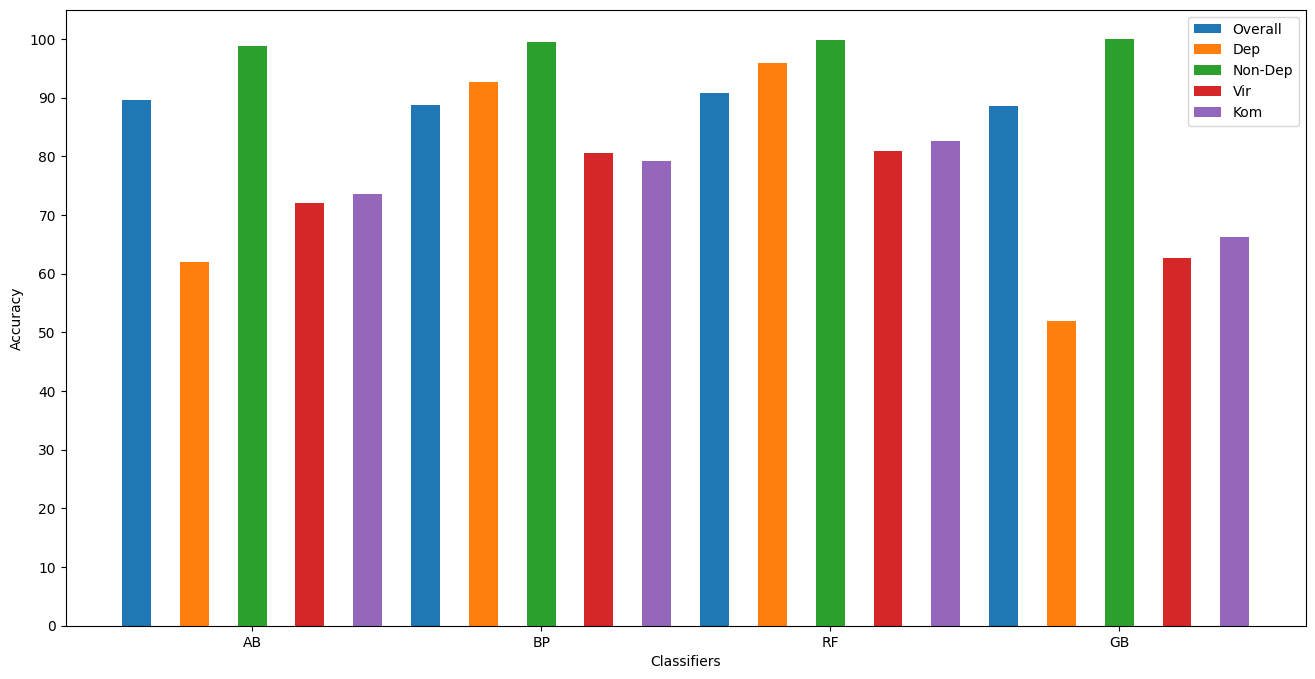

In [55]:
plt.figure(figsize=(16,8))
plt.bar(bar1, Ens_df['Acc'], label='Overall', align='edge', width=0.1)
plt.bar(bar2, Ens_df['Dep'], align='edge', width=0.1, label='Dep')
plt.bar(bar3, Ens_df['Non-Dep'], align='edge', width=0.1, label='Non-Dep')
plt.bar(bar4, Ens_df['Vir'], align='edge', width=0.1, label='Vir')
plt.bar(bar5, Ens_df['Kom'], align='edge', width=0.1, label='Kom')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.xticks(bar1+0.45, x)
plt.yticks(np.arange(0, 101, 10))
plt.legend(loc='upper right')
plt.show()